In [1]:
from plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

#functoin to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
#Loading the Dataset (MNIST)

input_size = 28*28
output_size = 10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train = False,
                   transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307,),(0.3081,))
                  ])),
    batch_size = 1000, shuffle=True
)

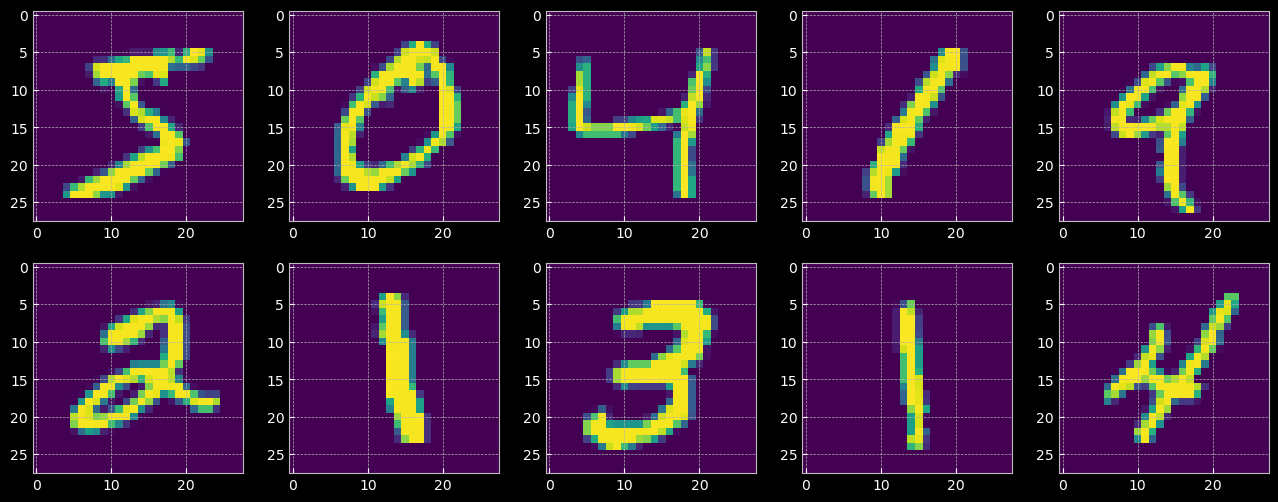

In [6]:
#show some images 
plt.figure(figsize = (16,6))
for i in range(10):
    plt.subplot(2,5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

# Model Classes

In [19]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# Running on a GPU: device string

In [21]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

# Train a small fully-connected Network

In [15]:
n_hidden = 8

model_fnn = FC2layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0,1):
    train(epoch, model_fnn)
    test(model_fnn)
    

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326147
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.877671
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.189280
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.838463
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.925227
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.557964
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.410461
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.275368
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.198124
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.391224

Test set: Average loss: 0.3871, Accuracy: 8880/10000 (89%)



In [22]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.327479
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.157589
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.599746
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.432459
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.288065
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.354222
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.308684
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.157965
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.101888
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.064731

Test set: Average loss: 0.1650, Accuracy: 9485/10000 (95%)



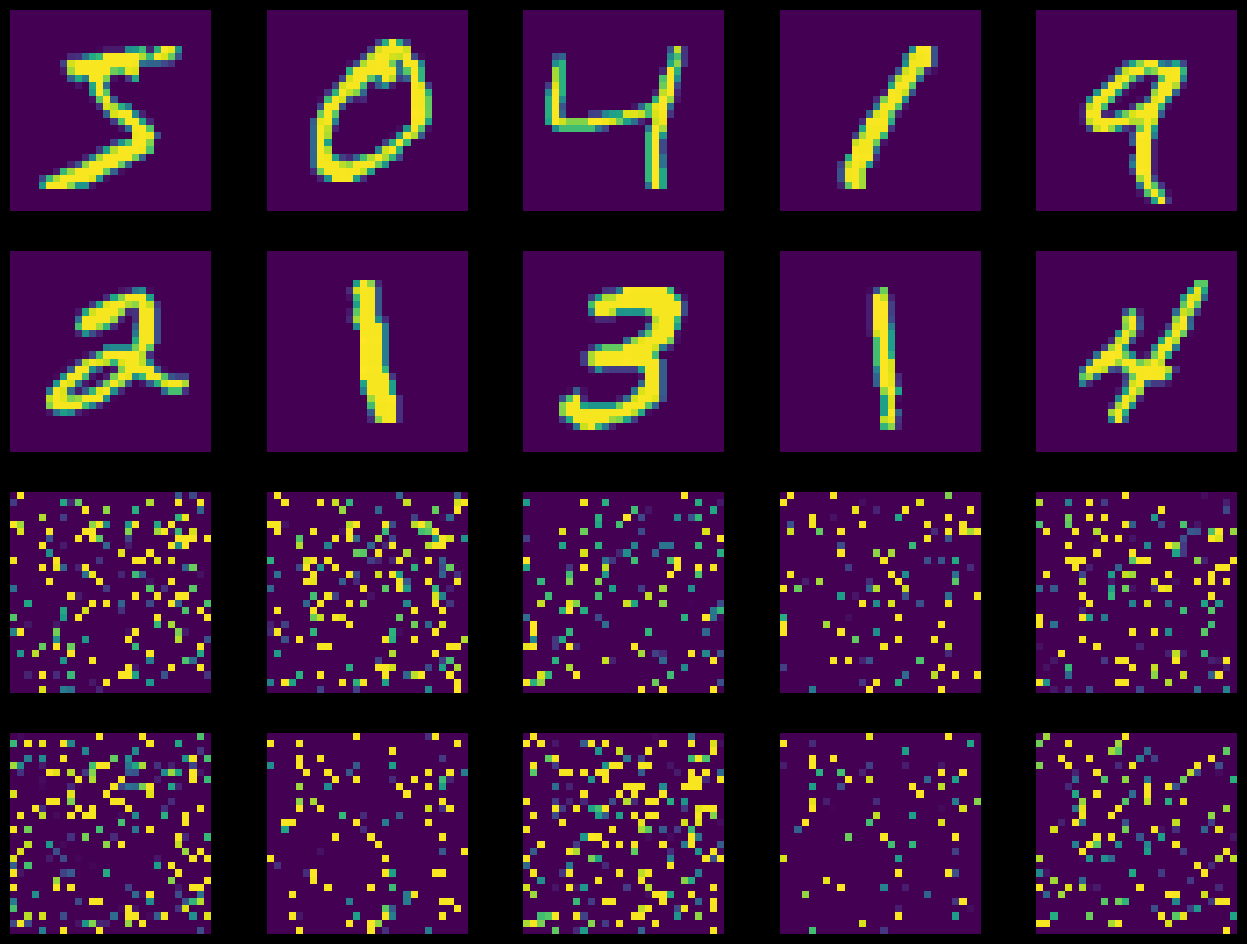

In [23]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')